# Configure Dependencies

In [1]:
!pip install matplotlib==3.4.0
!pip install -U yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown --id "1e3YPt-lQriFZvVjVUDKPdRb4NeYB2NQ5"
!gdown --id "1Uv0g11_Ttdo4xyffkwalY36egVQbV4PJ"
!gdown --id "1vv1l3uStNXoQ4hItg6YxDWjnvqrSYcOQ"

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1e3YPt-lQriFZvVjVUDKPdRb4NeYB2NQ5
To: /content/CustomerAnalysis.csv
100% 3.71k/3.71k [00:00<00:00, 5.69MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Uv0g11_Ttdo4xyffkwalY36egVQbV4PJ
To: /content/ProductAnalysis.csv
100% 98.0k/98.0k [00:00<00:00, 49.8MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import re
import seaborn as sns
import warnings

from plotly import tools
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from yellowbrick.cluster import SilhouetteVisualizer

In [4]:
os.chdir("/content")
warnings.filterwarnings("ignore")

# Helper Function

In [5]:
def convert_str_to_float(data):
    tmp = re.sub(",", ".", data)
    return float(tmp)

# Customer Analysis

In [6]:
col = [
    "customer_id",
    "city",
    "region",
    "country",
    "recency",
    "frequency",
    "monetary",
]

df_customer = pd.read_csv("CustomerAnalysis.csv", delimiter=";", names=col)
df_customer

,customer_id,city,region,country,recency,frequency,monetary
0,FISSA,Madrid,NaN,Spain,671,0,0
1,PARIS,Paris,NaN,France,671,0,0
2,ALFKI,Berlin,NaN,Germany,27,6,"4583,5"
3,ANATR,México D.F.,NaN,Mexico,63,4,"1402,95"
4,ANTON,México D.F.,NaN,Mexico,98,7,"7497,15"
...,...,...,...,...,...,...,...
86,WARTH,Oulu,NaN,Finland,21,15,"16580,6"
87,WELLI,Resende,SP,Brazil,58,9,"6465,75"
88,WHITC,Seattle,WA,USA,5,14,"28990,8"
89,WILMK,Helsinki,NaN,Finland,29,7,"3161,35"


In [7]:
df_customer.dtypes

customer_id    object
city           object
region         object
country        object
recency         int64
frequency       int64
monetary       object
dtype: object

In [8]:
df_customer['monetary'] = df_customer['monetary'].apply(convert_str_to_float)

## Experiment

### Approach 1

Using K-Means, without any changes at the feature 

In [9]:
features = df_customer.iloc[:,4:]

features

,recency,frequency,monetary
0,671,0,0.00
1,671,0,0.00
2,27,6,4583.50
3,63,4,1402.95
4,98,7,7497.15
...,...,...,...
86,21,15,16580.60
87,58,9,6465.75
88,5,14,28990.80
89,29,7,3161.35


In [10]:
min_cluster = 2
max_cluster = 5

sse = []
kmeans_obj = {}

for i in range(min_cluster, max_cluster+1):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(features)
    kmeans_obj[i] = kmeans
    sse.append(kmeans.inertia_)

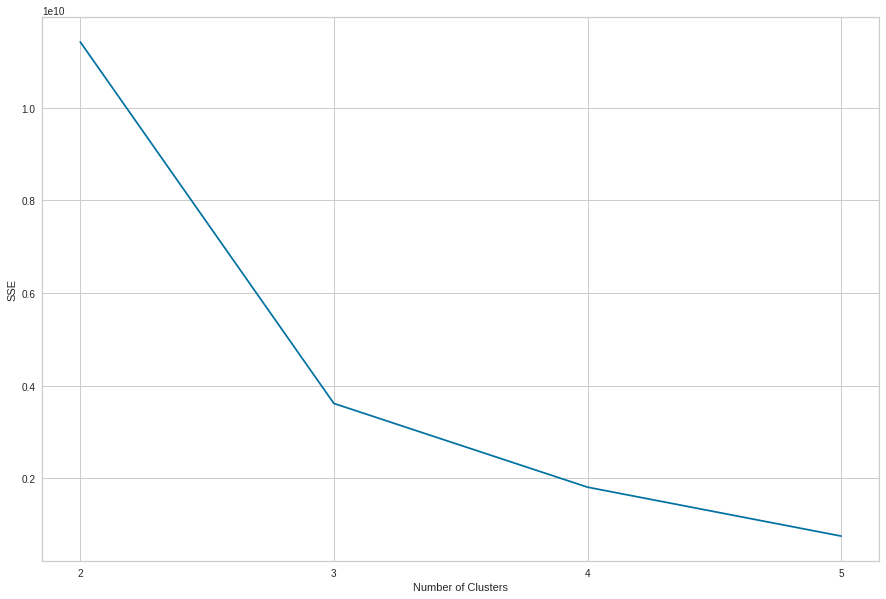

In [11]:
plt.figure(figsize=(15,10))
plt.plot(range(min_cluster, max_cluster+1), sse)
plt.xticks(range(min_cluster, max_cluster+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Silhoutte score for 2 clusters: 0.8791590658993618
Silhoutte score for 3 clusters: 0.6760163518534771
Silhoutte score for 4 clusters: 0.6891075015901692
Silhoutte score for 5 clusters: 0.6701321642510872


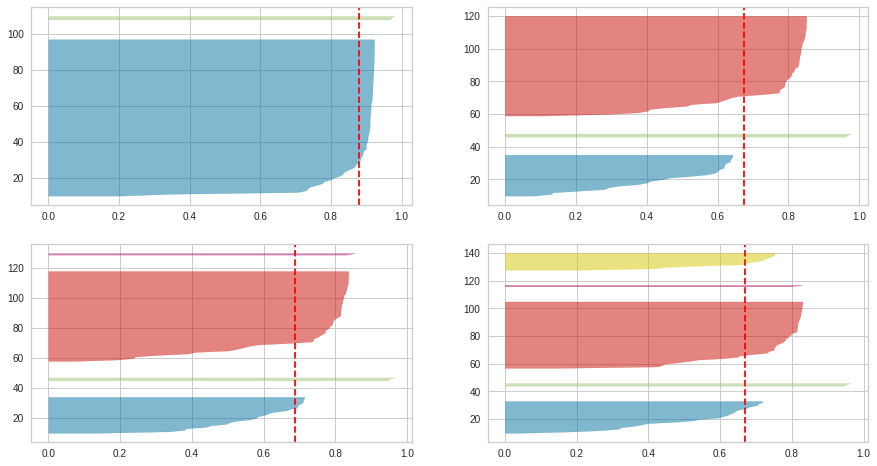

In [12]:
fig, ax = plt.subplots(2, int((max_cluster - min_cluster + 1)/2), figsize=(15,8))

for i in range(min_cluster, max_cluster+1):
    q, mod = divmod(i, 2)
    labels = kmeans_obj[i].predict(features)
    score = silhouette_score(features, labels)
    print("Silhoutte score for {} clusters: {}".format(i, score))
    visualizer = SilhouetteVisualizer(kmeans_obj[i], colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(features)

### Approach 2

Using K-Means, changing all of the used features value into ordinal type value based on its percentile distribution

In [13]:
features_q = features.quantile(q=[0.25,0.5,0.75]).to_dict()

print(features_q)

def get_fm_score(value, data):
    if value <= data[0.25]:
        return 1
    elif value > data[0.75] and value <= data[0.5]:
        return 2
    elif value > data[0.50] and value <= data[0.75]:
        return 3
    else:
        return 4 

def get_r_score(value, data):
    if value <= data[0.25]:
        return 4
    elif value > data[0.75] and value <= data[0.5]:
        return 3
    elif value > data[0.50] and value <= data[0.75]:
        return 2
    else:
        return 1

features['recency_ord'] = features['recency'].apply(get_r_score, data=features_q['recency'])
features['frequency_ord'] = features['frequency'].apply(get_fm_score, data=features_q['frequency'])
features['monetary_ord'] = features['monetary'].apply(get_fm_score, data=features_q['monetary'])

features

{'recency': {0.25: 8.5, 0.5: 26.0, 0.75: 61.5}, 'frequency': {0.25: 5.0, 0.5: 8.0, 0.75: 12.0}, 'monetary': {0.25: 3205.98, 0.5: 7497.15, 0.75: 17953.575}}


,recency,frequency,monetary,recency_ord,frequency_ord,monetary_ord
0,671,0,0.00,1,1,1
1,671,0,0.00,1,1,1
2,27,6,4583.50,2,4,4
3,63,4,1402.95,1,1,1
4,98,7,7497.15,1,4,4
...,...,...,...,...,...,...
86,21,15,16580.60,1,4,3
87,58,9,6465.75,2,3,4
88,5,14,28990.80,4,4,4
89,29,7,3161.35,2,4,1


In [14]:
min_cluster = 2
max_cluster = 5

sse = []
kmeans_obj_ordinal = {}

for i in range(min_cluster, max_cluster+1):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(features.iloc[:,3:])
    kmeans_obj_ordinal[i] = kmeans
    sse.append(kmeans.inertia_)

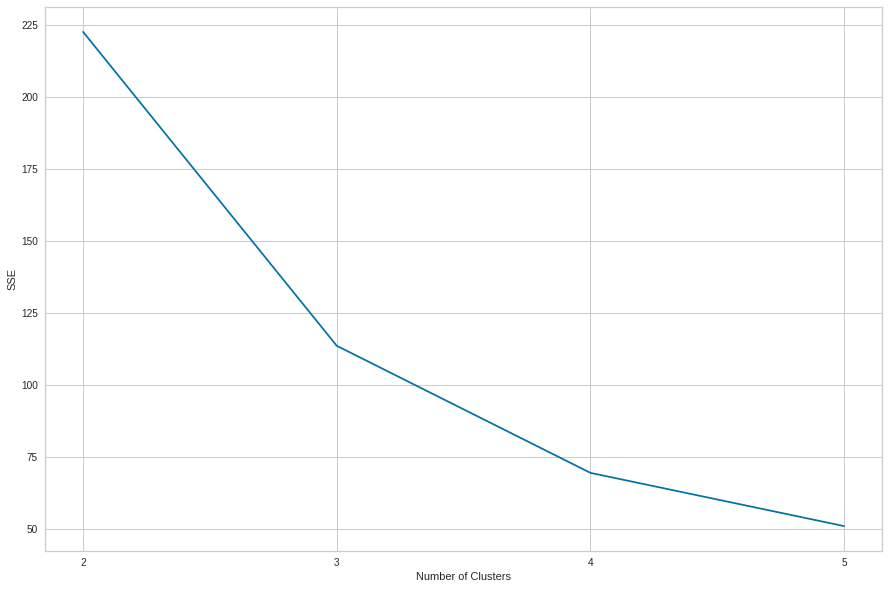

In [15]:
plt.figure(figsize=(15,10))
plt.plot(range(min_cluster, max_cluster+1), sse)
plt.xticks(range(min_cluster, max_cluster+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Silhoutte score for 2 clusters: 0.4942192257860774
Silhoutte score for 3 clusters: 0.5889490114779045
Silhoutte score for 4 clusters: 0.6519887677617872
Silhoutte score for 5 clusters: 0.67582481259387


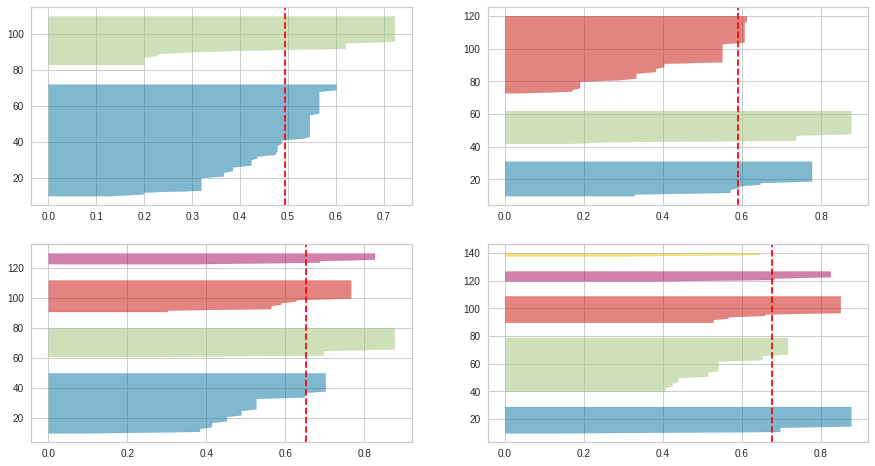

In [16]:
fig, ax = plt.subplots(2, int((max_cluster - min_cluster + 1)/2), figsize=(15,8))

for i in range(min_cluster, max_cluster+1):
    q, mod = divmod(i, 2)
    labels = kmeans_obj_ordinal[i].predict(features.iloc[:,3:])
    score = silhouette_score(features.iloc[:,3:], labels)
    print("Silhoutte score for {} clusters: {}".format(i, score))
    visualizer = SilhouetteVisualizer(kmeans_obj_ordinal[i], colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(features.iloc[:,3:])

### Conclusion

Using the information that has been got from the experiment, Approach (1) will be used to do the clustering process. It's because Approach(1) with 4 clusters has better silhoutte score and better elbow method condition among all of the other approach and number of clusters

## Analysis

### Cluster Analysis

In [17]:
number_of_cluster = 4

model = kmeans_obj[number_of_cluster]

df_customer['cluster'] = model.predict(features.iloc[:,0:3]) + 1

df_customer

,customer_id,city,region,country,recency,frequency,monetary,cluster
0,FISSA,Madrid,NaN,Spain,671,0,0.00,3
1,PARIS,Paris,NaN,France,671,0,0.00,3
2,ALFKI,Berlin,NaN,Germany,27,6,4583.50,3
3,ANATR,México D.F.,NaN,Mexico,63,4,1402.95,3
4,ANTON,México D.F.,NaN,Mexico,98,7,7497.15,3
...,...,...,...,...,...,...,...,...
86,WARTH,Oulu,NaN,Finland,21,15,16580.60,1
87,WELLI,Resende,SP,Brazil,58,9,6465.75,3
88,WHITC,Seattle,WA,USA,5,14,28990.80,1
89,WILMK,Helsinki,NaN,Finland,29,7,3161.35,3


In [18]:
count_cluster = df_customer['cluster'].value_counts()
count_cluster_df = pd.DataFrame({'cluster':count_cluster.index, 'count':count_cluster.values})
count_cluster_df

,cluster,count
0,3,61
1,1,25
2,2,3
3,4,2


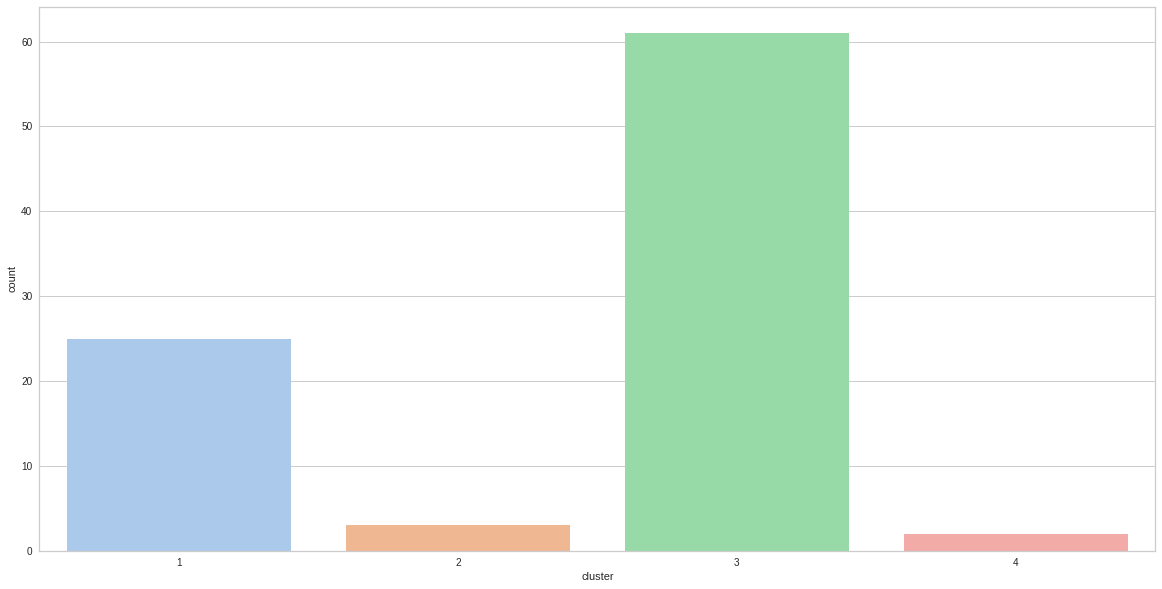

In [19]:
plt.figure(figsize=(20,10))
sns.barplot(x='cluster', y='count', data=count_cluster_df, palette='pastel')
plt.savefig("./cluster_barplot.png")
plt.show() 

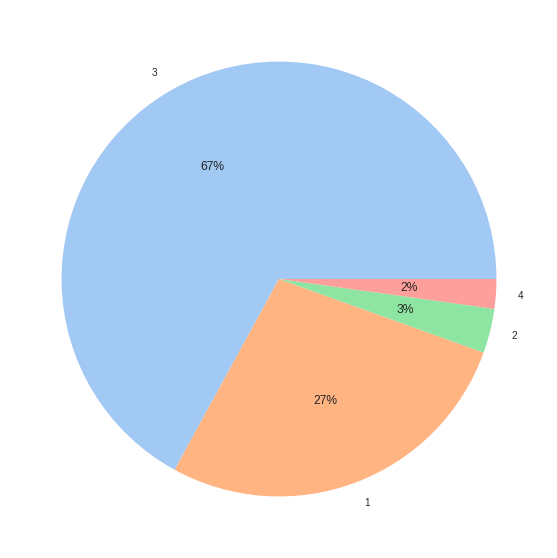

In [20]:
count_dct = df_customer['cluster'].value_counts().to_dict() 
data = list(count_dct.values())
label = list(count_dct.keys())

colors = sns.color_palette('pastel')[0:len(label)]

plt.figure(figsize=(10,10))
plt.pie(data, labels = label, colors = colors, autopct='%.0f%%')
plt.savefig("./cluster_pieplot.png")
plt.show()

**Most of the customers** (67%) are being categorized as **cluster 3**

In [21]:
def visualize_boxplot(data, attr, group='cluster'):
    plt.figure(figsize=(10,10))
    sns.boxplot(x=data[group], y=data[attr], palette='pastel')
    plt.savefig("./cluster_{}_boxplot.png".format(attr))
    plt.show()

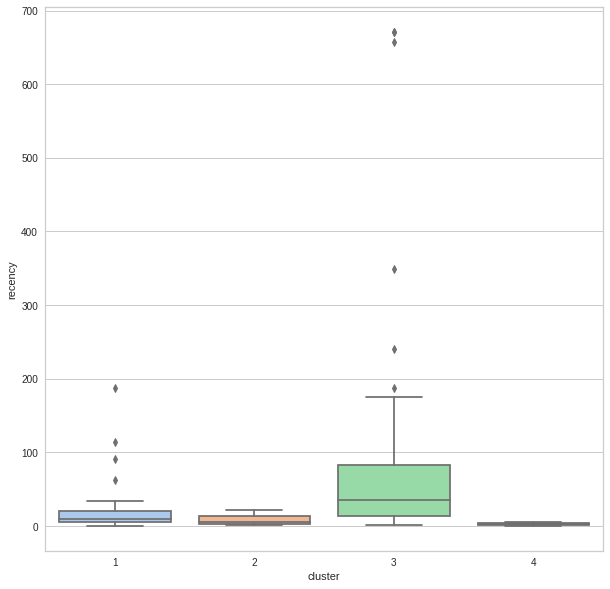

In [22]:
visualize_boxplot(df_customer, 'recency')

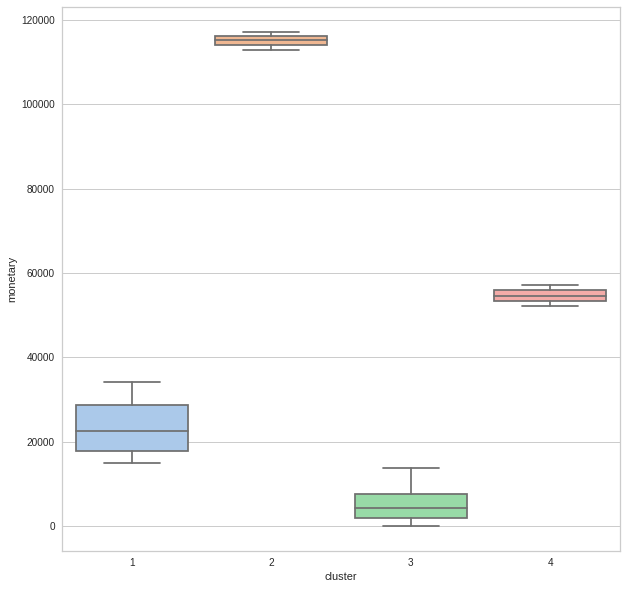

In [23]:
visualize_boxplot(df_customer, 'monetary')

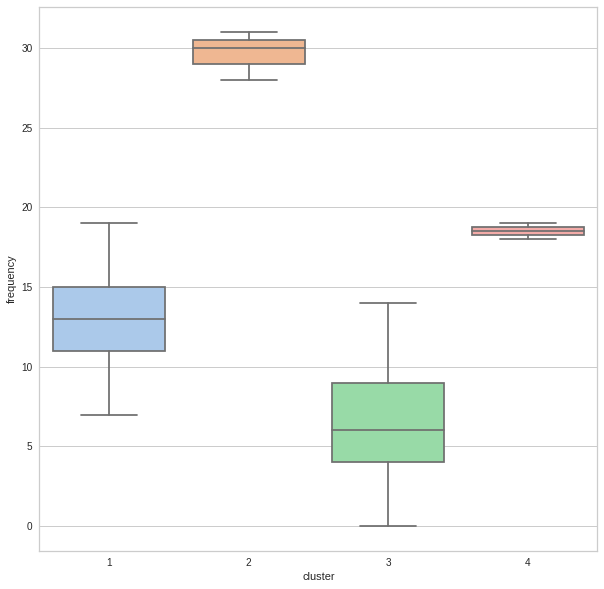

In [24]:
visualize_boxplot(df_customer, 'frequency')

Based on several boxplot above, we can conclude that **attribute that can differentiate** each customer are **frequency** and **monetary**. On those two attributes boxplot, there were such a **huge difference in the distribution of each cluster**. Meanwhile on recency attribute, the difference of the distribution on each cluster is very small. Using the information that are displayed on the boxplot, we can summarize each cluster as:

*  **Cluster 1: Medium-Low Customers**, because they have a fairly small number of transactions and spent a few amount of money, but not as few as Cluster 1 (Best Customers) 
*  **Cluster 2: Best Customers**, because they already done many transaction and have spent a lot of money 
* **Cluster 3: Low Customers**, because they have small number of transaction and spent a little amount of money 
* **Cluster 4: Medium-High Customers**, because they have a large enough number of transactions and spent a lot of money, but not as much as Cluster 1 (Best Customers) 



### Customer Distribution Based On Cluster & Country

In [25]:
customer_count = df_customer['country'].value_counts().to_dict()
customer_count 

{'USA': 13,
 'Germany': 11,
 'France': 11,
 'Brazil': 9,
 'UK': 7,
 'Spain': 5,
 'Mexico': 5,
 'Venezuela': 4,
 'Canada': 3,
 'Argentina': 3,
 'Italy': 3,
 'Finland': 2,
 'Denmark': 2,
 'Belgium': 2,
 'Austria': 2,
 'Portugal': 2,
 'Switzerland': 2,
 'Sweden': 2,
 'Ireland': 1,
 'Norway': 1,
 'Poland': 1}

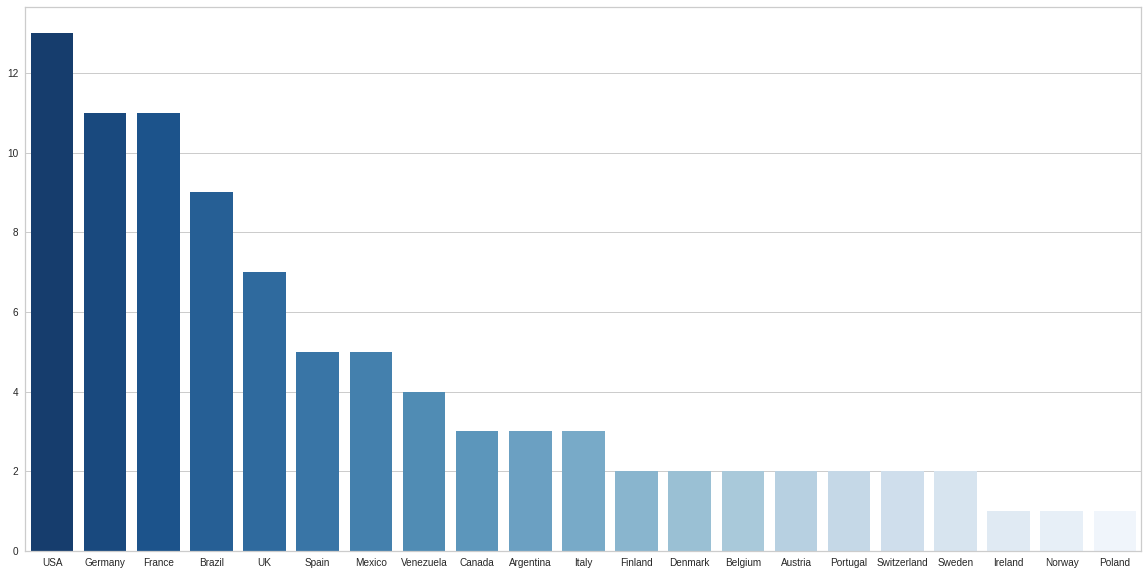

In [26]:
pal = sns.color_palette("Blues", len(customer_count))
plt.figure(figsize=(20,10))
sns.barplot(x=list(customer_count.keys()), y=list(customer_count.values()), palette=pal[::-1])
plt.savefig("./country_barplot.png")
plt.show()

In [27]:
threshold = np.quantile(list(customer_count.values()), q=0.75)
current_sum = 0
total = df_customer.shape[0]

aggregated = {}

for key in customer_count.keys():
    if customer_count[key] >= threshold:
        aggregated[key] = customer_count[key]
        current_sum += customer_count[key]
    else:
        if "Others" not in aggregated.keys():
            aggregated["Others"] = customer_count[key]
        else:
            aggregated["Others"] += customer_count[key]

print("Number of countries that being top 75% countries based on customer count: {}".format(len(aggregated)-1))
print("Total customer at top 75% countries based on customer count: {}".format(current_sum))
print("Ratio: {}%".format(round(current_sum/total * 100, 2)))

Number of countries that being top 75% countries based on customer count: 7
Total customer at top 75% countries based on customer count: 61
Ratio: 67.03%


In [28]:
top_countries = [country for country in aggregated.keys() if country != "Others"]

filtered_df_costumer = df_customer[df_customer['country'].isin(top_countries)]
grouped_filtered_df_customer = filtered_df_costumer.groupby(["country", "cluster"]).size().reset_index(name="count")
grouped_filtered_df_customer

,country,cluster,count
0,Brazil,1,2
1,Brazil,3,7
2,France,1,2
3,France,3,9
4,Germany,1,3
5,Germany,2,1
6,Germany,3,7
7,Mexico,3,5
8,Spain,3,5
9,UK,1,2


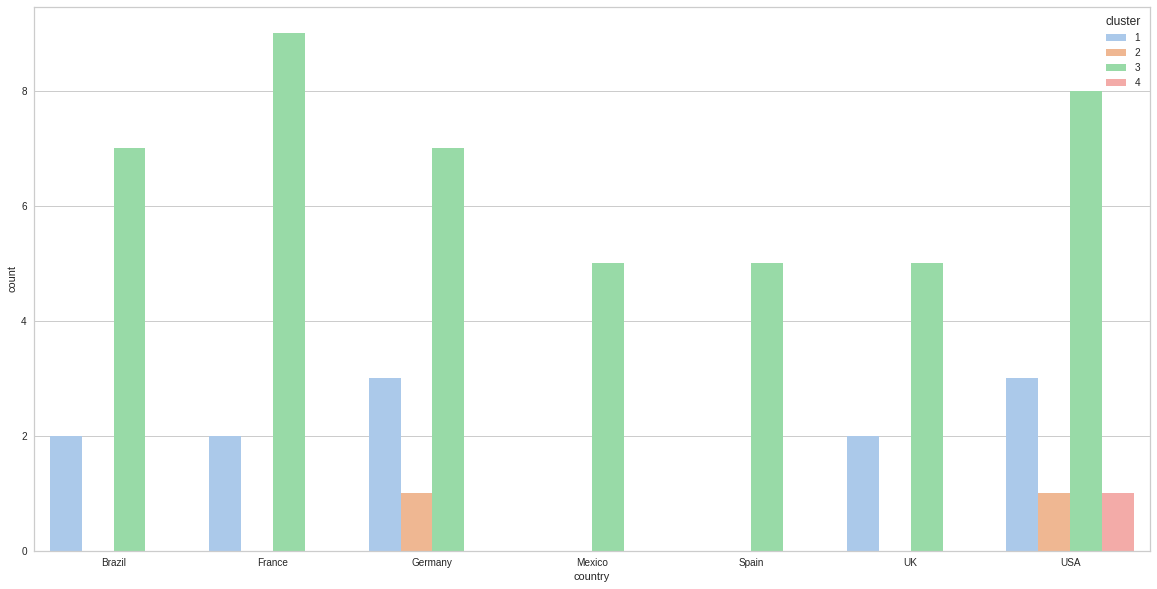

In [29]:
plt.figure(figsize=(20,10))
sns.barplot(x='country', y='count', hue='cluster', data=grouped_filtered_df_customer, palette='pastel')
plt.savefig("./cluster_country_barplot.png")
plt.show() 

From the graph above, we can conclude that **on every country, most of its customer is on Cluster 3 (Low Customer) group**. On each country beside Mexico and Spain, they still have customer on the other cluster group although still being dominated with Cluster 1 (Medium-Low Customer). Therefore, there must be effort to improve customer behaviour in term of recency, frequency, and monetary especially on Mexico and Spain where all of their customers are in Cluster 3 (Low Customer) group

# Product Analysis

In [30]:
col = [
    "year",
    "month",
    "product_id",
    "product_name",
    "category",
    "transaction_count",
    "avg_product_price",
    "avg_order_price",
    "avg_price_gap",
    "total_gross",
    "total_nett",
    "avg_total_gross",
    "avg_total_nett"
]

df_product = pd.read_csv("ProductAnalysis.csv", delimiter=";", names=col)
df_product

,year,month,product_id,product_name,category,transaction_count,avg_product_price,avg_order_price,avg_price_gap,total_gross,total_nett,avg_total_gross,avg_total_nett
0,1996,7,2,Chang,Beverages,3,"19,00","15,20","3,80","1596,00",1586,"532,00","528,67"
1,1996,7,5,Chef Anton's Gumbo Mix,Condiments,2,"21,35","17,00","4,35","1309,00","1293,6","654,50","646,8"
2,1996,7,7,Uncle Bob's Organic Dried Pears,Produce,1,"30,00","24,00","6,00","360,00",360,"360,00",360
3,1996,7,11,Queso Cabrales,Dairy Products,1,"21,00","14,00","7,00","168,00",168,"168,00",168
4,1996,7,12,Queso Manchego La Pastora,Dairy Products,1,"38,00","30,40","7,60","364,80","364,2","364,80","364,2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,1998,5,68,Scottish Longbreads,Confections,1,"12,50","12,50","0,00","687,50","687,5","687,50","687,5"
1158,1998,5,73,Röd Kaviar,Seafood,1,"15,00","15,00","0,00","30,00","29,98","30,00","29,98"
1159,1998,5,75,Rhönbräu Klosterbier,Beverages,1,"7,75","7,75","0,00","31,00",31,"31,00",31
1160,1998,5,76,Lakkalikööri,Beverages,1,"18,00","18,00","0,00","36,00","35,7","36,00","35,7"


In [31]:
converted_col = [
    "avg_product_price",
    "avg_order_price",
    "avg_price_gap",
    "total_gross",
    "total_nett",
    "avg_total_gross",
    "avg_total_nett"
]

for col in converted_col:
    df_product[col] = df_product[col].apply(convert_str_to_float)

df_product

,year,month,product_id,product_name,category,transaction_count,avg_product_price,avg_order_price,avg_price_gap,total_gross,total_nett,avg_total_gross,avg_total_nett
0,1996,7,2,Chang,Beverages,3,19.00,15.20,3.80,1596.0,1586.00,532.0,528.67
1,1996,7,5,Chef Anton's Gumbo Mix,Condiments,2,21.35,17.00,4.35,1309.0,1293.60,654.5,646.80
2,1996,7,7,Uncle Bob's Organic Dried Pears,Produce,1,30.00,24.00,6.00,360.0,360.00,360.0,360.00
3,1996,7,11,Queso Cabrales,Dairy Products,1,21.00,14.00,7.00,168.0,168.00,168.0,168.00
4,1996,7,12,Queso Manchego La Pastora,Dairy Products,1,38.00,30.40,7.60,364.8,364.20,364.8,364.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,1998,5,68,Scottish Longbreads,Confections,1,12.50,12.50,0.00,687.5,687.50,687.5,687.50
1158,1998,5,73,Röd Kaviar,Seafood,1,15.00,15.00,0.00,30.0,29.98,30.0,29.98
1159,1998,5,75,Rhönbräu Klosterbier,Beverages,1,7.75,7.75,0.00,31.0,31.00,31.0,31.00
1160,1998,5,76,Lakkalikööri,Beverages,1,18.00,18.00,0.00,36.0,35.70,36.0,35.70


In [32]:
def reformat(data):
    if len(str(data)) == 1:
        return "0{}".format(data)
    else:
        return data

df_product['month'] = df_product['month'].apply(reformat)

lst_year_month = ["{}-{}".format(df_product.iloc[i,0], df_product.iloc[i,1]) for i in range(df_product.shape[0])]
df_product.insert(2, 'year_month', lst_year_month)
df_product

,year,month,year_month,product_id,product_name,category,transaction_count,avg_product_price,avg_order_price,avg_price_gap,total_gross,total_nett,avg_total_gross,avg_total_nett
0,1996,07,1996-07,2,Chang,Beverages,3,19.00,15.20,3.80,1596.0,1586.00,532.0,528.67
1,1996,07,1996-07,5,Chef Anton's Gumbo Mix,Condiments,2,21.35,17.00,4.35,1309.0,1293.60,654.5,646.80
2,1996,07,1996-07,7,Uncle Bob's Organic Dried Pears,Produce,1,30.00,24.00,6.00,360.0,360.00,360.0,360.00
3,1996,07,1996-07,11,Queso Cabrales,Dairy Products,1,21.00,14.00,7.00,168.0,168.00,168.0,168.00
4,1996,07,1996-07,12,Queso Manchego La Pastora,Dairy Products,1,38.00,30.40,7.60,364.8,364.20,364.8,364.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,1998,05,1998-05,68,Scottish Longbreads,Confections,1,12.50,12.50,0.00,687.5,687.50,687.5,687.50
1158,1998,05,1998-05,73,Röd Kaviar,Seafood,1,15.00,15.00,0.00,30.0,29.98,30.0,29.98
1159,1998,05,1998-05,75,Rhönbräu Klosterbier,Beverages,1,7.75,7.75,0.00,31.0,31.00,31.0,31.00
1160,1998,05,1998-05,76,Lakkalikööri,Beverages,1,18.00,18.00,0.00,36.0,35.70,36.0,35.70


In [33]:
df_product = df_product[df_product['year_month'] != '1998-05']
df_product['year_month'] = pd.to_datetime(df_product['year_month'], format='%Y-%m')
df_product

,year,month,year_month,product_id,product_name,category,transaction_count,avg_product_price,avg_order_price,avg_price_gap,total_gross,total_nett,avg_total_gross,avg_total_nett
0,1996,07,1996-07-01,2,Chang,Beverages,3,19.00,15.20,3.80,1596.0,1586.00,532.00,528.67
1,1996,07,1996-07-01,5,Chef Anton's Gumbo Mix,Condiments,2,21.35,17.00,4.35,1309.0,1293.60,654.50,646.80
2,1996,07,1996-07-01,7,Uncle Bob's Organic Dried Pears,Produce,1,30.00,24.00,6.00,360.0,360.00,360.00,360.00
3,1996,07,1996-07-01,11,Queso Cabrales,Dairy Products,1,21.00,14.00,7.00,168.0,168.00,168.00,168.00
4,1996,07,1996-07-01,12,Queso Manchego La Pastora,Dairy Products,1,38.00,30.40,7.60,364.8,364.20,364.80,364.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,1998,04,1998-04-01,72,Mozzarella di Giovanni,Dairy Products,2,34.80,34.80,0.00,1287.6,1287.60,643.80,643.80
1118,1998,04,1998-04-01,74,Longlife Tofu,Produce,1,10.00,10.00,0.00,200.0,200.00,200.00,200.00
1119,1998,04,1998-04-01,75,Rhönbräu Klosterbier,Beverages,1,7.75,7.75,0.00,232.5,232.50,232.50,232.50
1120,1998,04,1998-04-01,76,Lakkalikööri,Beverages,3,18.00,18.00,0.00,2628.0,2605.00,876.00,868.33


In [34]:
df_product['total_loss'] = df_product['avg_price_gap'] * df_product['transaction_count']
df_product

,year,month,year_month,product_id,product_name,category,transaction_count,avg_product_price,avg_order_price,avg_price_gap,total_gross,total_nett,avg_total_gross,avg_total_nett,total_loss
0,1996,07,1996-07-01,2,Chang,Beverages,3,19.00,15.20,3.80,1596.0,1586.00,532.00,528.67,11.4
1,1996,07,1996-07-01,5,Chef Anton's Gumbo Mix,Condiments,2,21.35,17.00,4.35,1309.0,1293.60,654.50,646.80,8.7
2,1996,07,1996-07-01,7,Uncle Bob's Organic Dried Pears,Produce,1,30.00,24.00,6.00,360.0,360.00,360.00,360.00,6.0
3,1996,07,1996-07-01,11,Queso Cabrales,Dairy Products,1,21.00,14.00,7.00,168.0,168.00,168.00,168.00,7.0
4,1996,07,1996-07-01,12,Queso Manchego La Pastora,Dairy Products,1,38.00,30.40,7.60,364.8,364.20,364.80,364.20,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,1998,04,1998-04-01,72,Mozzarella di Giovanni,Dairy Products,2,34.80,34.80,0.00,1287.6,1287.60,643.80,643.80,0.0
1118,1998,04,1998-04-01,74,Longlife Tofu,Produce,1,10.00,10.00,0.00,200.0,200.00,200.00,200.00,0.0
1119,1998,04,1998-04-01,75,Rhönbräu Klosterbier,Beverages,1,7.75,7.75,0.00,232.5,232.50,232.50,232.50,0.0
1120,1998,04,1998-04-01,76,Lakkalikööri,Beverages,3,18.00,18.00,0.00,2628.0,2605.00,876.00,868.33,0.0


## Analysis

### Gross Income

In [35]:
gross_income_data = df_product.groupby(['year_month'])['total_nett', 'total_loss'].sum().reset_index()
gross_income_data

,year_month,total_nett,total_loss
0,1996-07-01,30075.20,300.69
1,1996-08-01,26549.80,373.08
2,1996-09-01,27592.50,336.23
3,1996-10-01,41052.35,402.13
4,1996-11-01,49612.10,459.86
5,1996-12-01,50769.55,483.40
6,1997-01-01,66526.15,521.80
7,1997-02-01,41050.50,378.77
8,1997-03-01,39885.15,418.46
9,1997-04-01,55589.34,54.10


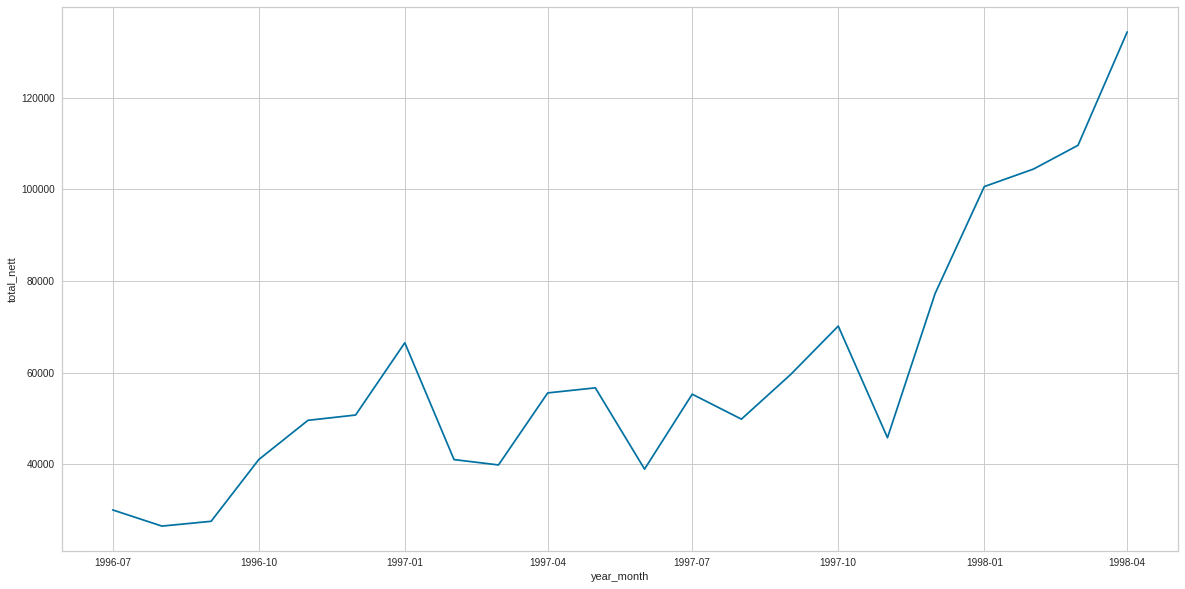

In [36]:
plt.figure(figsize=(20,10))
sns.lineplot(data=gross_income_data, x='year_month', y='total_nett', palette='pastel')
plt.savefig("./gross_income.png")
plt.show()

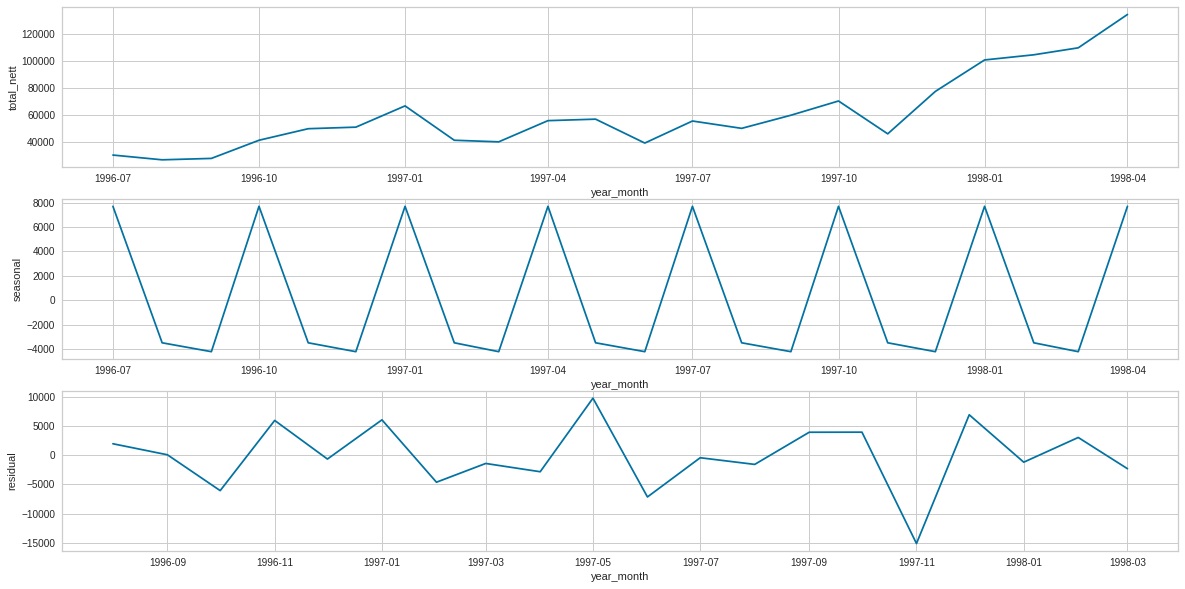

In [37]:
decompose_data = gross_income_data.set_index("year_month")

decompose = seasonal_decompose(gross_income_data['total_nett'],model='additive', period=3)
observed = decompose.observed
seasonal = decompose.seasonal
residual = decompose.resid

df_decompose = pd.DataFrame({"total_nett":observed, "seasonal":seasonal,"residual":residual})
df_decompose['year_month'] = gross_income_data['year_month']

_, axes = plt.subplots(nrows=3,ncols=1, figsize=(20, 10))
for i, ax in enumerate(axes):
    sns.lineplot(data=df_decompose, x='year_month', y=df_decompose.columns[i], palette='pastel', ax=ax)

plt.savefig("./gross_income_decompose.png")
plt.show()

From several graphs above, we can conclude that **the gross income that has been obtained is fluctuating** on each month. However, in general if we take a look **on the trend, the gross income that has been obtained is increasing**. Also, the gross income that has been obtained **have a seasonal pattern which is repeated every 3 months**. At the seasonal pattern, the gross income will have highest growth on the first month and the growth will be decreasing on the other months.

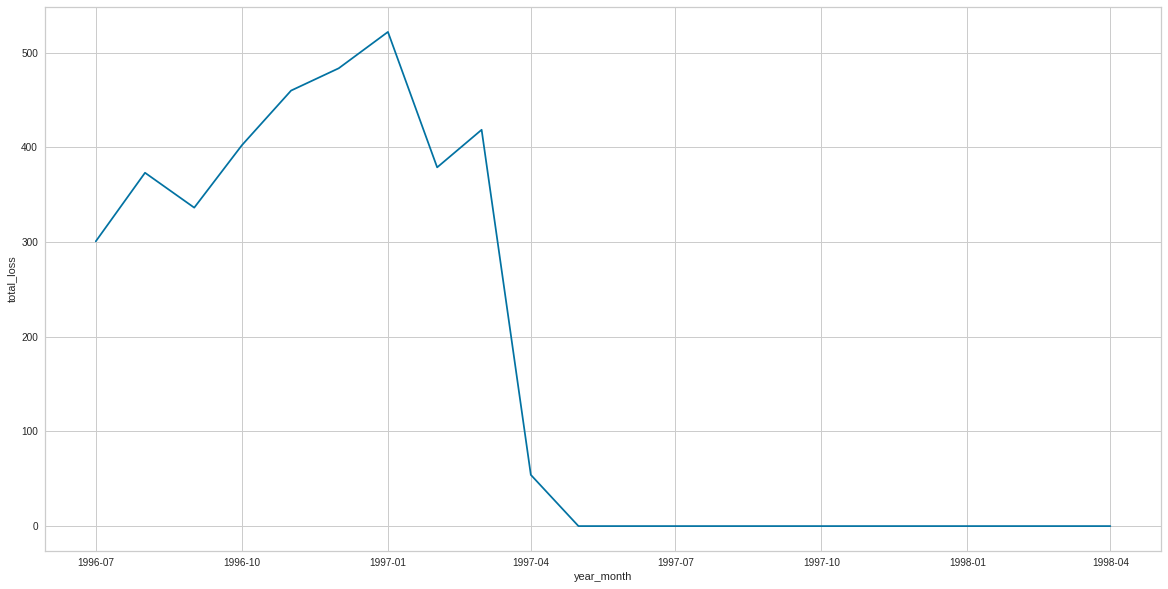

In [38]:
plt.figure(figsize=(20,10))
sns.lineplot(data=gross_income_data, x='year_month', y='total_loss', palette='pastel')
plt.savefig("./total_loss.png")
plt.show()

Also, from the graph above, we can conclude that **in the early period of the data, there were several losses** which caused by **differences price value on the product data and order data**. The value is increasing for a short time period but also it remain decreasing for the next time period so that in current data, the loss remains zero

### Most Popular Product Category

In [39]:
product_performance_data = df_product.groupby(['year_month', 'category'])['transaction_count'].sum().reset_index()
product_performance_data.sort_values(['year_month', 'transaction_count'], inplace=True, ascending=[True, False])
product_performance_data.reset_index(inplace=True, drop=True)
product_performance_data["rank"] = product_performance_data.groupby("year_month")["transaction_count"].rank(method="first", ascending=False)
product_performance_data

,year_month,category,transaction_count,rank
0,1996-07-01,Dairy Products,12,1.0
1,1996-07-01,Beverages,11,2.0
2,1996-07-01,Confections,8,3.0
3,1996-07-01,Seafood,7,4.0
4,1996-07-01,Condiments,6,5.0
...,...,...,...,...
171,1998-04-01,Condiments,20,4.0
172,1998-04-01,Confections,17,5.0
173,1998-04-01,Grains/Cereals,16,6.0
174,1998-04-01,Meat/Poultry,13,7.0


In [40]:
top = 3
popular_product_data = product_performance_data[product_performance_data['rank'] <= top]
popular_product_data['year_month'] = popular_product_data['year_month'].apply(lambda x: str(x)[0:7]) 
popular_product_data

,year_month,category,transaction_count,rank
0,1996-07,Dairy Products,12,1.0
1,1996-07,Beverages,11,2.0
2,1996-07,Confections,8,3.0
8,1996-08,Beverages,16,1.0
9,1996-08,Dairy Products,13,2.0
...,...,...,...,...
161,1998-03,Confections,31,2.0
162,1998-03,Seafood,30,3.0
168,1998-04,Beverages,40,1.0
169,1998-04,Dairy Products,36,2.0


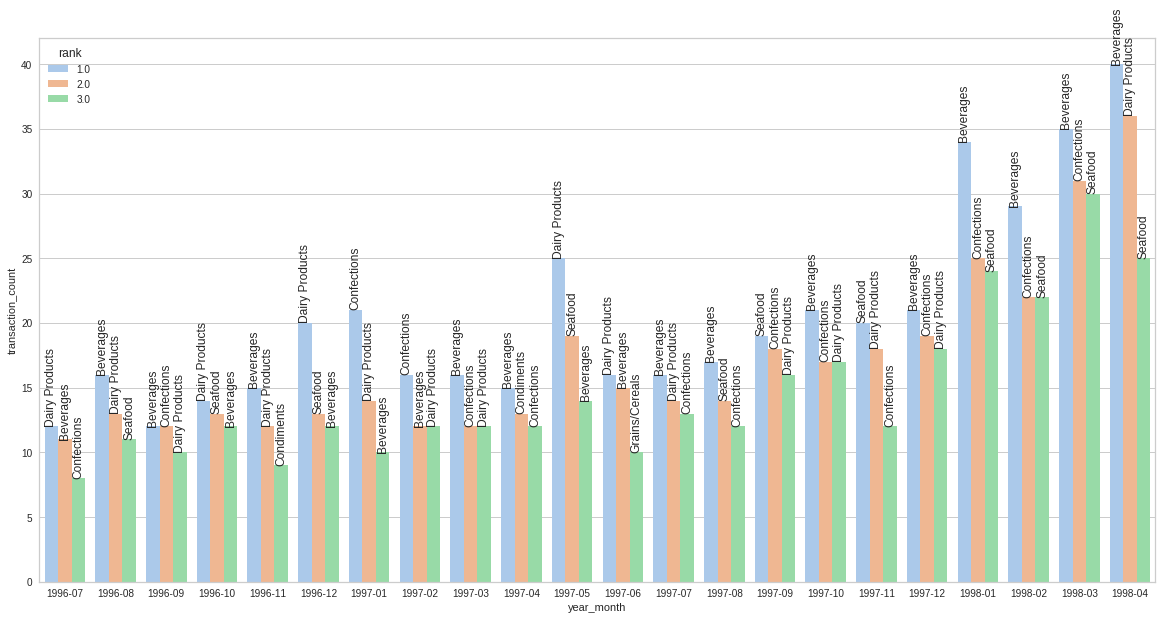

In [41]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data=popular_product_data, x='year_month', y='transaction_count', hue='rank', palette='pastel')

label = [
    list(popular_product_data[popular_product_data['rank'] == float(rank)]['category']) for rank in range(1,4)
]

index = 0

for container in ax.containers:
    used_label = label[index]
    ax.bar_label(container, labels=used_label, rotation=90)
    index += 1 

plt.savefig("./top_3_each_month.png")
plt.show()

From the graph above, we can conclude that **differences on the top-3 category that being most purchased on each month**. 

Number of months: 22


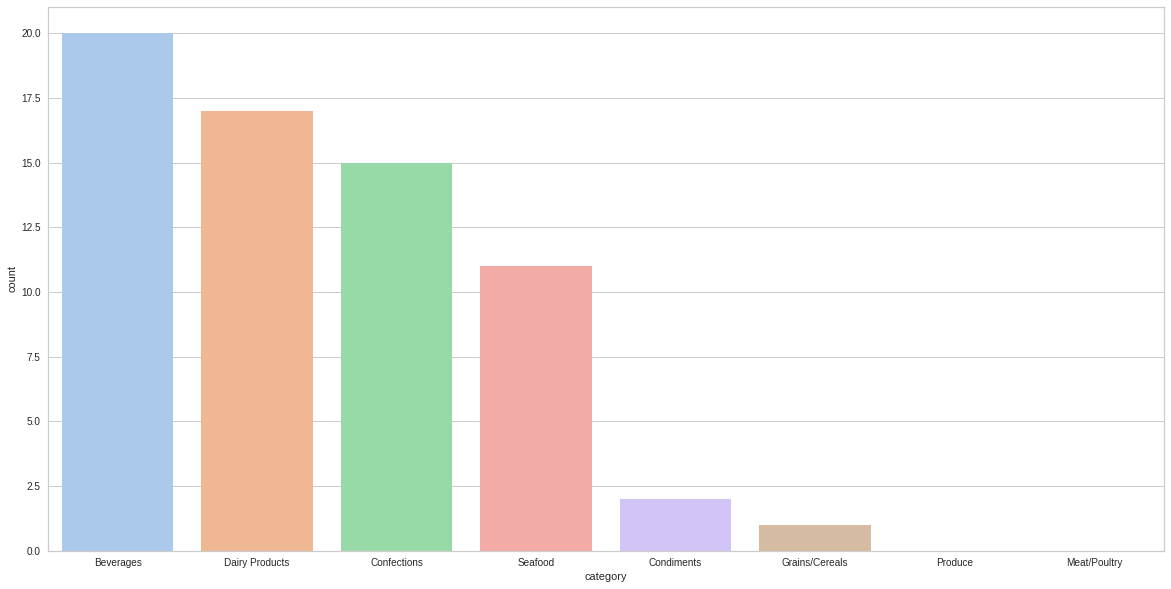

In [42]:
category_count = popular_product_data.groupby('category').size().reset_index(name="count")
category_count.sort_values(by='count', ascending=False, inplace=True)
category_count.reset_index(inplace=True, drop=True)

all_cat = list(set(df_product['category']))
for cat in all_cat:
    if cat not in list(category_count['category']):
        category_count.loc[len(category_count)] = [cat, 0]


print("Number of months: {}".format(len(set(df_product['year_month']))))

plt.figure(figsize=(20,10))
sns.barplot(data=category_count, x='category', y='count', palette='pastel')
plt.savefig("./top_3_aggregated.png")
plt.show()

In order to aggregate the previous data, the number of occurences of each category on the top-3 category on each month data is being computed. Based on the computation result and the graph above, we can conclude that **'Beverages', 'Diary Products', and 'Confections' is the most popular product category** because their number of occurrences is being the most among all of the product category

# Supplier Analysis

In [43]:
col = [
    "product_id",
    "product_name",
    "category",
    "supplier_company",
    "is_discontinued",
    "reorder_level",
    "unit_in_stock",
    "now_gap",
    "future_unit",
    "future_gap",
    "order_count",
    "total_gross_income",
    "prev_month_demand",
    "prev_month_order"
]

df_supplier = pd.read_csv("SupplierAnalysis.csv", delimiter=";", names=col)
df_supplier

,product_id,product_name,category,supplier_company,is_discontinued,reorder_level,unit_in_stock,now_gap,future_unit,future_gap,order_count,total_gross_income,prev_month_demand,prev_month_order
0,1,Chai,Beverages,Exotic Liquids,0,10,39,29,39,29,38,"14192,15",144,8
1,2,Chang,Beverages,Exotic Liquids,0,25,17,-8,57,32,44,"18434,8",263,9
2,3,Aniseed Syrup,Condiments,Exotic Liquids,0,25,13,-12,83,58,12,3076,29,2
3,4,Chef Anton's Cajun Seasoning,Condiments,New Orleans Cajun Delights,0,0,53,53,53,53,20,"9384,85",26,2
4,5,Chef Anton's Gumbo Mix,Condiments,New Orleans Cajun Delights,1,0,0,0,0,0,10,"5776,75",100,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Röd Kaviar,Seafood,Svensk Sjöföda AB,0,5,101,96,101,96,14,"4185,28",2,1
73,74,Longlife Tofu,Produce,Tokyo Traders,0,5,4,-1,24,19,13,"2550,25",20,1
74,75,Rhönbräu Klosterbier,Beverages,Plutzer Lebensmittelgroßmärkte AG,0,25,125,100,125,100,46,"8588,65",34,2
75,76,Lakkalikööri,Beverages,Karkki Oy,0,20,57,37,57,37,39,16733,148,4


In [44]:
converted_col = ['total_gross_income']

for col in converted_col:
    df_supplier[col] = df_supplier[col].apply(convert_str_to_float)

In [45]:
lst_supplier = list(set(df_supplier['supplier_company']))
lst_supplier

['Karkki Oy',
 "G'day, Mate",
 'Exotic Liquids',
 'Plutzer Lebensmittelgroßmärkte AG',
 'Pavlova, Ltd.',
 'Refrescos Americanas LTDA',
 'Nord-Ost-Fisch Handelsgesellschaft mbH',
 "Grandma Kelly's Homestead",
 'Aux joyeux ecclésiastiques',
 'New England Seafood Cannery',
 'Bigfoot Breweries',
 'Leka Trading',
 'Svensk Sjöföda AB',
 'Ma Maison',
 'Heli Süßwaren GmbH & Co. KG',
 'Formaggi Fortini s.r.l.',
 'Norske Meierier',
 'Pasta Buttini s.r.l.',
 "Forêts d'érables",
 'Lyngbysild',
 "Mayumi's",
 'Specialty Biscuits, Ltd.',
 'Tokyo Traders',
 'Zaanse Snoepfabriek',
 "Cooperativa de Quesos 'Las Cabras'",
 'Escargots Nouveaux',
 'Gai pâturage',
 'New Orleans Cajun Delights',
 'PB Knäckebröd AB']

## Analytics

### Supplier Performance

In [46]:
grouped_df_supplier = df_supplier.groupby(['supplier_company']) \
                    .agg({
                        'total_gross_income': 'sum',
                        'product_id': 'count'
                    }) \
                    .reset_index() \
                    .rename(columns={
                        'product_id': 'product_count'
                    })

grouped_df_supplier['ratio'] = grouped_df_supplier['total_gross_income']/grouped_df_supplier['product_count']

grouped_df_supplier

,supplier_company,total_gross_income,product_count,ratio
0,Aux joyeux ecclésiastiques,163043.70,2,81521.850000
1,Bigfoot Breweries,23685.20,3,7895.066667
2,Cooperativa de Quesos 'Las Cabras',26701.55,2,13350.775000
3,Escargots Nouveaux,6600.65,1,6600.650000
4,Exotic Liquids,35702.95,3,11900.983333
5,Formaggi Fortini s.r.l.,50922.45,3,16974.150000
6,Forêts d'érables,66136.95,2,33068.475000
7,"G'day, Mate",69523.00,3,23174.333333
8,Gai pâturage,126370.23,2,63185.115000
9,Grandma Kelly's Homestead,43517.93,3,14505.976667


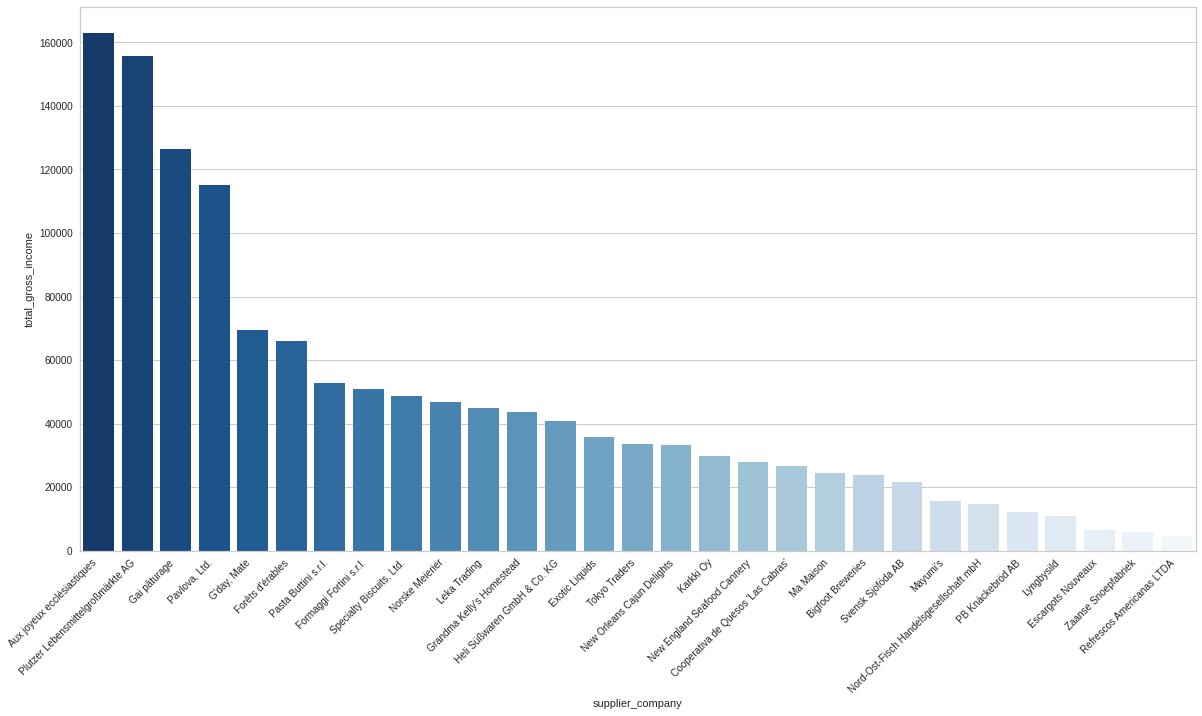

In [47]:
ordered_by_total_gross = grouped_df_supplier.sort_values(by=['total_gross_income'], ascending=False)
ordered_by_total_gross.reset_index(inplace=True, drop=True)

pal = sns.color_palette("Blues", len(ordered_by_total_gross))

plt.figure(figsize=(20,10))
sns.barplot(data=ordered_by_total_gross, x='supplier_company', y='total_gross_income', palette=pal[::-1])
plt.xticks(rotation=45, ha='right')
plt.savefig("./supplier_performance_gross_income")
plt.show()

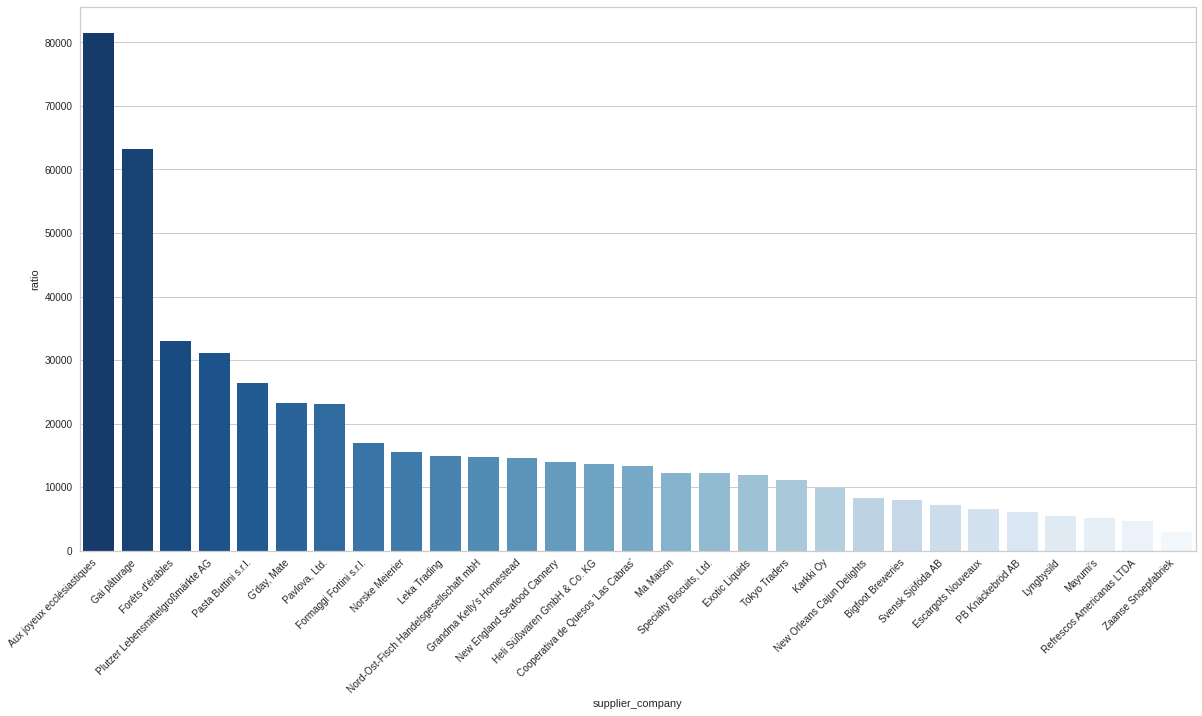

In [48]:
ordered_by_ratio = grouped_df_supplier.sort_values(by=['ratio'], ascending=False)
ordered_by_ratio.reset_index(inplace=True, drop=True)

pal = sns.color_palette("Blues", len(ordered_by_ratio))

plt.figure(figsize=(20,10))
sns.barplot(data=ordered_by_ratio, x='supplier_company', y='ratio', palette=pal[::-1])
plt.xticks(rotation=45, ha='right')
plt.savefig("./supplier_performance_ratio")
plt.show()

From those two graphs above, we can conclude that **there were differences in the order of suppliers based on total gross income that has been obtained through their products and the ratio between total gross income and the number of products that they were provided**. Higher ratio on a supplier means that every product that are being supplied by it have a higher total gross income value.Therefore, we could know that there were several suppliers have higher total gross income but lower ratio and vice versa, and it can be used to indicated whether supplier has best performance based on several point of view

### Restock 

**Used assumption**: When a product is having a restock, the number of stock must be added until it reach its reorder level if the number of reorder level is higher than the prediction of next month demand (previous month demand multiplied by 0.8). And if not, the number of stock must be added until it reach its previous month demand multiplied by 0.8 and added by 5

Note that 0.8 and 5 is several value to keep the product not being overstock/understock to fulfill the next month demand. Future research can be conducted to determine those value 

In [49]:
def get_restock_value(data):
    if (0.8 * data['prev_month_demand']) < data['reorder_level']:
        return immediate_restock['reorder_level'] - immediate_restock['future_unit']
    else:
        return int((0.8 * data['prev_month_demand']) - data['future_unit']) + 5

In [50]:
immediate_restock = df_supplier[(df_supplier['future_gap'] <= 0) & (df_supplier['is_discontinued'] == 0)]
immediate_restock

,product_id,product_name,category,supplier_company,is_discontinued,reorder_level,unit_in_stock,now_gap,future_unit,future_gap,order_count,total_gross_income,prev_month_demand,prev_month_order
29,30,Nord-Ost Matjeshering,Seafood,Nord-Ost-Fisch Handelsgesellschaft mbH,0,15,10,-5,10,-5,32,14717.09,19,2
69,70,Outback Lager,Beverages,"Pavlova, Ltd.",0,30,15,-15,25,-5,39,11415.80,69,5


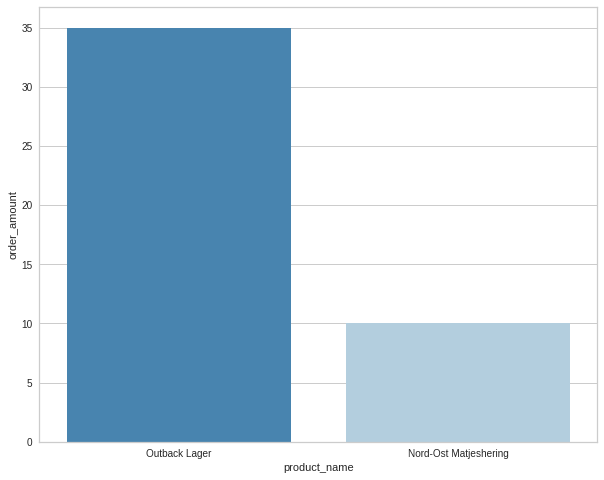

In [51]:
immediate_restock['order_amount'] = [get_restock_value(immediate_restock.iloc[i,:]) for i in range(immediate_restock.shape[0])]
immediate_restock.sort_values(by=['order_amount'], ascending=False, inplace=True)
immediate_restock.reset_index(inplace=True, drop=True)

pal = sns.color_palette("Blues", len(immediate_restock))

plt.figure(figsize=(10,8))
sns.barplot(data=immediate_restock, x='product_name', y='order_amount', palette=pal[::-1])
plt.savefig("./supplier_restock_order_level")
plt.show()

From the graph above, we could know that **there were two products that need to be restock as soon as possible** because their number of stock are lower than their number of reorder level. The number of stock must be added into a specific amount to fulfil next month demand

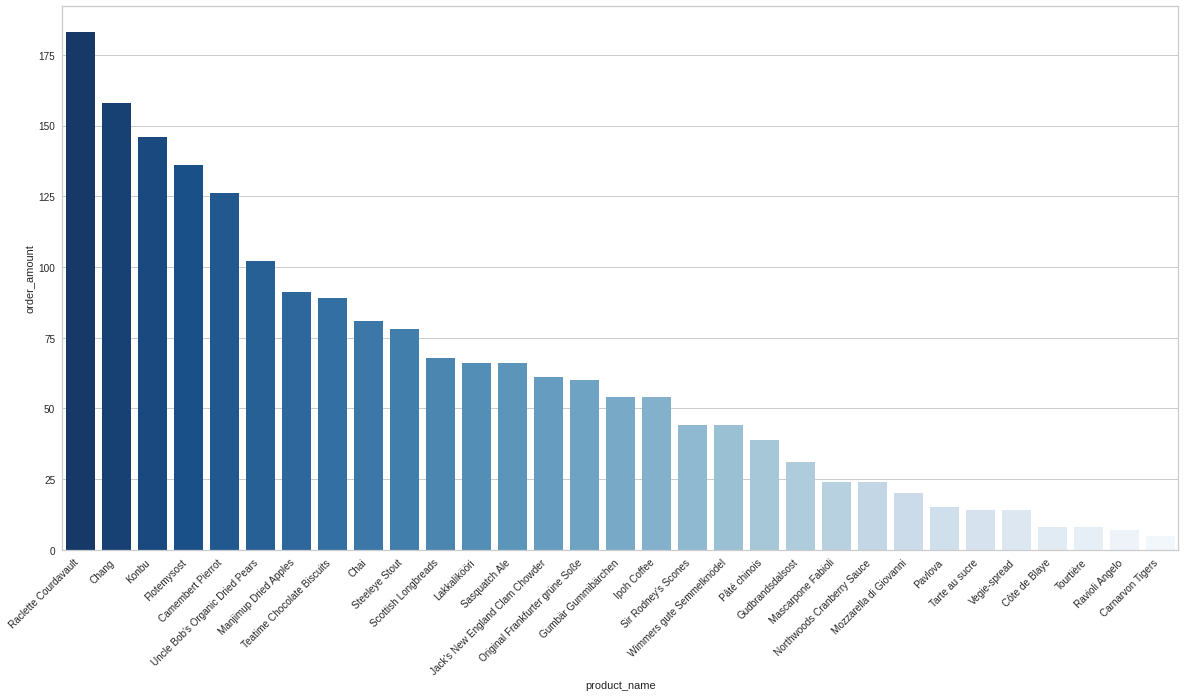

In [52]:
future_restock = df_supplier[(df_supplier['future_gap'] > 0) \
            & (df_supplier['is_discontinued'] == 0) \
            & ((0.8 * df_supplier['prev_month_demand']) > df_supplier['future_unit'])]

future_restock['order_amount'] = [get_restock_value(future_restock.iloc[i,:]) for i in range(future_restock.shape[0])]
future_restock.sort_values(by=['order_amount'], ascending=False, inplace=True)
future_restock.reset_index(inplace=True, drop=True)

pal = sns.color_palette("Blues", len(future_restock))

plt.figure(figsize=(20,10))
sns.barplot(data=future_restock, x='product_name', y='order_amount', palette=pal[::-1])
plt.xticks(rotation=45, ha='right')
plt.savefig("./supplier_restock_demand")
plt.show()

From the graph above, we could know that **there were several products that need to be restock** because their number of stock are lower than their number of stock that must be achieved in order to fulfill next month demand. The number of stock that must be added to each product are varying.